In [1]:
import numpy as np
import os
import argparse
from GridDataGen.utils.io import *
from GridDataGen.utils.process_network import *
from GridDataGen.utils.config import *
from GridDataGen.utils.stats import *
from GridDataGen.utils.param_handler import *
from GridDataGen.utils.load import *
from pandapower.auxiliary import pandapowerNet
import gc
from datetime import datetime
from tqdm import tqdm
import psutil
import shutil
import yaml
from GridDataGen.utils.process_network import process_scenario_contingency
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


# makedir comparison
os.makedirs("comparison", exist_ok=True)



# Functions to compute branch current

In [2]:
def compute_branch_currents_kA(Yf, Yt, V, Vf_base_kV, Vt_base_kV, sn_mva):

    
    If_pu = Yf @ V  # From-end currents in per-unit (I_f = Y_f V)
    If_kA = np.abs(If_pu) * sn_mva / (np.sqrt(3) * Vf_base_kV)  # Conversion to kA

    # Construct to-end admittance matrix Yt:
    # Yt[b, :] = y_tf_b * e_f + y_tt_b * e_t
    It_pu = Yt @ V  # To-end currents in per-unit (I_t = Y_t V)
    It_kA = np.abs(It_pu) * sn_mva / (np.sqrt(3) * Vt_base_kV)  # Conversion to kA


    return If_kA, It_kA


def compute_loading(If_kA, It_kA, Vf_base_kV, Vt_base_kV, rate_a):
    """
    Compute per-branch loading using current magnitudes and branch ratings.

    Parameters:
    - edge_index: np.ndarray of shape (n_edges, 2), each row is [from_bus, to_bus]
    - If_kA: np.ndarray of from-side current magnitudes in kA
    - It_kA: np.ndarray of to-side current magnitudes in kA
    - base_kv: np.ndarray of shape (n_buses,), base voltage in kV per bus
    - edge_attr: np.ndarray of shape (n_edges, >=5), edge features, column 4 = RATE_A

    Returns:
    - loading: np.ndarray of shape (n_edges,), max of from and to side loading
    """

    limitf = rate_a / (Vf_base_kV * np.sqrt(3))
    limitt = rate_a / (Vt_base_kV * np.sqrt(3))

    loadingf = If_kA / limitf
    loadingt = It_kA / limitt

    return np.maximum(loadingf, loadingt)

# Load data

In [3]:
# pf_node = pd.read_csv("../../data_contingency/case300_ieee/merged/GridFM_v0.1.2_case300_ieee_output_pf_node.csv")
pf_node_contingency= pd.read_csv("../../data_contingency/case300_ieee/merged/Alban_Contingency_GridFM_v0.1.2_case300_ieee_output_pf_node.csv")
pf_node_no_pretraining = pd.read_csv("../../data_contingency/case300_ieee/merged/Contingency_GridFM_v0.1.2_no_pretraining_Alban_case300_ieee_output_pf_node.csv")
pf_node_no_finetuning = pd.read_csv("../../data_contingency/case300_ieee/merged/no_finetuning_case300_Alban.csv")
pf_node_ft_pf_ft_contingency = pd.read_csv("../../data_contingency/case300_ieee/merged/ft_pf_ft_contingency_case300_Alban.csv")
pf_node_ft_pf = pd.read_csv("../../data_contingency/case300_ieee/merged/ft_pf_model_case300_Alban.csv")
pf_node_ft_contingency_ieee118 = pd.read_csv("../../data_contingency/case300_ieee/merged/contingency_case118_case300_Alban.csv")
branch_idx_removed = pd.read_csv("../../data_contingency/case300_ieee/raw/branch_idx_removed.csv")
edge_params = pd.read_csv("../../data_contingency/case300_ieee/raw/edge_params.csv")
bus_params = pd.read_csv("../../data_contingency/case300_ieee/raw/bus_params.csv")
load_profile = pd.read_csv("../../data_contingency/case300_ieee/raw/scenarios_powergraph.csv")

In [4]:
pf_node = {"no_pretraining": pf_node_no_pretraining, "ft_pf_ft_contingency": pf_node_ft_pf_ft_contingency,"contingency":pf_node_contingency,  "ft_pf": pf_node_ft_pf,  "ft_contingency_ieee118": pf_node_ft_contingency_ieee118, "no_finetuning": pf_node_no_finetuning }
labels = {"contingency": "GridFM FT on contingency", "no_pretraining": "Specialized model", "no_finetuning": "GridFM (without FT)", "ft_pf_ft_contingency": "GridFM FT on PF, then FT on contingency", "ft_pf": "GridFM FT on PF", "ft_contingency_ieee118": "GridFM FT on contingency for IEEE 118"}

In [5]:
# assert all pf_node have the same scenario
for key, value in pf_node.items():
    assert np.all(value.scenario.unique() == pf_node["contingency"].scenario.unique())


# Create Admittance matrix

In [6]:
base_kv = bus_params["baseKV"].values
sn_mva = 100

# Extract from-bus and to-bus indices for each branch

f = edge_params["from_bus"].values.astype(np.int32)
t = edge_params["to_bus"].values.astype(np.int32)

# Extract branch admittance coefficients
Yff = edge_params["Yff_r"].values + 1j * edge_params["Yff_i"].values
Yft = edge_params["Yft_r"].values + 1j * edge_params["Yft_i"].values
Ytf = edge_params["Ytf_r"].values + 1j * edge_params["Ytf_i"].values
Ytt = edge_params["Ytt_r"].values + 1j * edge_params["Ytt_i"].values

# Get base voltages for the from and to buses (for kA conversion)
Vf_base_kV = base_kv[f]
Vt_base_kV = base_kv[t]

nl = edge_params.shape[0]
nb = bus_params.shape[0]

# i = [0, 1, ..., nl-1, 0, 1, ..., nl-1], used for constructing Yf and Yt
i = np.hstack([np.arange(nl), np.arange(nl)])

# Construct from-end admittance matrix Yf using the linear combination:
# Yf[b, :] = y_ff_b * e_f + y_ft_b * e_t
Yf = csr_matrix((np.hstack([Yff, Yft]), (i, np.hstack([f, t]))), shape=(nl, nb))
Yt = csr_matrix((np.hstack([Ytf, Ytt]), (i, np.hstack([f, t]))), shape=(nl, nb))

rate_a = edge_params["rate_a"].values

# Correct voltage predictions

In [7]:

len(pf_node)

for key, value in pf_node.items():
    value["Vm_pred_corrected"] = value["VM_pred"]
    value["Va_pred_corrected"] = value["VA_pred"]
    value.loc[value.PV==1, "Vm_pred_corrected"] = value.loc[value.PV==1, "Vm"]
    value.loc[value.REF==1, "Va_pred_corrected"] = value.loc[value.REF==1, "Va"]

    value["Vm_dc_corrected"] = value["Vm_dc"]
    value["Va_dc_corrected"] = value["Va_dc"]
    value.loc[value.PV==1, "Vm_dc_corrected"] = value.loc[value.PV==1, "Vm"]
    value.loc[value.REF==1, "Va_dc_corrected"] = value.loc[value.REF==1, "Va"]

# assert all dc values are the same 
for key, value in pf_node.items():
    print(key)
    assert np.all(value["Vm_dc_corrected"] == pf_node["contingency"]["Vm_dc_corrected"])
    assert np.all(value["Va_dc_corrected"] == pf_node["contingency"]["Va_dc_corrected"])




no_pretraining
ft_pf_ft_contingency
contingency
ft_pf
ft_contingency_ieee118
no_finetuning


# Compute branch current and loading

In [8]:
loadings_pred = {}

# Compute loadings and dc once (from "contingency")
value = pf_node["contingency"]
loadings = []
loadings_dc = []

for scenario_idx in tqdm(value.scenario.unique(), desc="Computing ground truth & DC"):
    pf_node_scenario = value[value.scenario == scenario_idx]
    branch_idx_removed_scenario = branch_idx_removed[branch_idx_removed.scenario == scenario_idx].iloc[:, 1:].values
    branch_idx_removed_scenario = branch_idx_removed_scenario[~np.isnan(branch_idx_removed_scenario)].astype(np.int32)

    V_true = pf_node_scenario["Vm"].values * np.exp(1j * pf_node_scenario["Va"].values * np.pi / 180)
    V_dc = pf_node_scenario["Vm_dc_corrected"].values * np.exp(1j * pf_node_scenario["Va_dc_corrected"].values * np.pi / 180)

    If_true, It_true = compute_branch_currents_kA(Yf, Yt, V_true, Vf_base_kV, Vt_base_kV, sn_mva)
    If_dc, It_dc = compute_branch_currents_kA(Yf, Yt, V_dc, Vf_base_kV, Vt_base_kV, sn_mva)

    loading_true = compute_loading(If_true, It_true, Vf_base_kV, Vt_base_kV, rate_a)
    loading_dc_case = compute_loading(If_dc, It_dc, Vf_base_kV, Vt_base_kV, rate_a)

    loading_true[branch_idx_removed_scenario] = -1
    loading_dc_case[branch_idx_removed_scenario] = -1

    loadings.append(loading_true)
    loadings_dc.append(loading_dc_case)

loadings = np.array(loadings)
loadings_dc = np.array(loadings_dc)

# Compute loadings_pred for each prediction case
for key in pf_node.keys():
    loadings_pred[key] = []

    for scenario_idx in tqdm(pf_node[key].scenario.unique(), desc=f"Computing predictions: {key}"):
        pf_node_scenario = pf_node[key][pf_node[key].scenario == scenario_idx]
        branch_idx_removed_scenario = branch_idx_removed[branch_idx_removed.scenario == scenario_idx].iloc[:, 1:].values
        branch_idx_removed_scenario = branch_idx_removed_scenario[~np.isnan(branch_idx_removed_scenario)].astype(np.int32)

        V_pred = pf_node_scenario["Vm_pred_corrected"].values * np.exp(1j * pf_node_scenario["Va_pred_corrected"].values * np.pi / 180)
        If_pred, It_pred = compute_branch_currents_kA(Yf, Yt, V_pred, Vf_base_kV, Vt_base_kV, sn_mva)
        loading_pred_case = compute_loading(If_pred, It_pred, Vf_base_kV, Vt_base_kV, rate_a)
        loading_pred_case[branch_idx_removed_scenario] = -1

        loadings_pred[key].append(loading_pred_case)

    loadings_pred[key] = np.array(loadings_pred[key])


Computing predictions: no_finetuning: 100%|██████████| 10230/10230 [00:24<00:00, 409.84it/s]


In [9]:
# Compute removed lines masks
removed_lines = (loadings == -1)
removed_lines_dc = (loadings_dc == -1)
removed_lines_pred = {key: (loadings_pred[key] == -1) for key in loadings_pred}

# Assert: all removed lines match between GT and DC
assert np.all(removed_lines == removed_lines_dc)

# Assert: all removed lines match between GT and each prediction
for key in loadings_pred:
    print(key)
    assert np.all(removed_lines == removed_lines_pred[key])
    assert removed_lines.sum() == removed_lines_pred[key].sum()


no_pretraining
ft_pf_ft_contingency
contingency
ft_pf
ft_contingency_ieee118
no_finetuning


In [10]:
overloadings = loadings[removed_lines==False] > 1


# Find best threshold for classification for GridFM

AUROC GridFM-FT (no_pretraining): 0.9990139505468361
AUROC GridFM-FT (ft_pf_ft_contingency): 0.9984664592123526
AUROC GridFM-FT (contingency): 0.9981051229629668
AUROC GridFM-FT (ft_pf): 0.9901120631739228
AUROC DC (shared): 0.9971373989293424


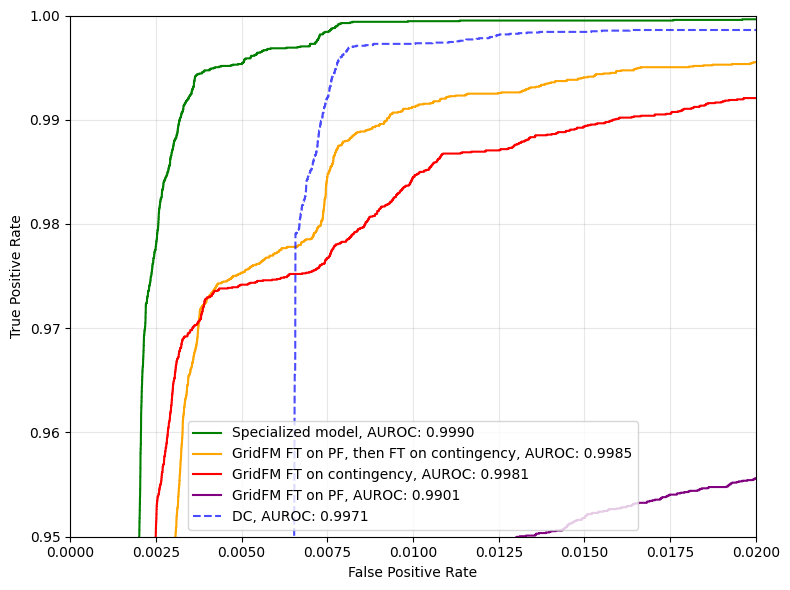

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Store results
roc_data = {}

# Compute DC ROC once (shared)
mask = removed_lines == False
y_score_dc = loadings_dc[mask]
fpr_dc, tpr_dc, thresholds_dc = roc_curve(overloadings, y_score_dc)
auc_dc = auc(fpr_dc, tpr_dc)

models = ["no_pretraining","ft_pf_ft_contingency","contingency", "ft_pf" ]

# Compute ROC curves and AUCs for each model prediction
for key in models:
    y_true = overloadings
    y_score_pred = loadings_pred[key][mask]

    fpr_pred, tpr_pred, thresholds_pred = roc_curve(y_true, y_score_pred)
    roc_data[key] = {
        "fpr_pred": fpr_pred,
        "tpr_pred": tpr_pred,
        "thresholds_pred": thresholds_pred,
        "auc_pred": auc(fpr_pred, tpr_pred)
    }

# Plotting
plt.figure(figsize=(8, 6))
target_thresholds = np.arange(0.80, 1.00, 0.02)
colors = {"contingency": "red", "no_pretraining": "green", "ft_pf_ft_contingency": "orange", "ft_pf": "purple"}
linestyles = {"GridFM": "-", "DC": "--"}

# Plot GridFM curves and annotate thresholds
for key in models:
    plt.plot(roc_data[key]["fpr_pred"], roc_data[key]["tpr_pred"],
             label=f"{labels[key]}, AUROC: {roc_data[key]['auc_pred']:.4f}", linestyle=linestyles["GridFM"], color=colors[key])

    # for threshold in target_thresholds:
        # idx_pred = np.abs(roc_data[key]["thresholds_pred"] - threshold).argmin()
        # plt.plot(roc_data[key]["fpr_pred"][idx_pred], roc_data[key]["tpr_pred"][idx_pred],
        #          'o', color=colors[key], markersize=4)
        # # add annotation
        # plt.annotate(f"{threshold:.2f}", (roc_data[key]["fpr_pred"][idx_pred], roc_data[key]["tpr_pred"][idx_pred]), fontsize=10)

# Plot shared DC curve and annotate thresholds once
plt.plot(fpr_dc, tpr_dc, label=f"DC, AUROC: {auc_dc:.4f}", linestyle=linestyles["DC"], color="blue", alpha=0.7)
# for threshold in target_thresholds:
#     idx_dc = np.abs(thresholds_dc - threshold).argmin()
#     plt.plot(fpr_dc[idx_dc], tpr_dc[idx_dc], 's', color="blue", markersize=4, alpha=0.5)
#     # add annotation
#     plt.annotate(f"{threshold:.2f}", (fpr_dc[idx_dc], tpr_dc[idx_dc]), fontsize=10)

# Final touches
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 0.02)
plt.ylim(0.95, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Print AUCs
for key in models:
    print(f"AUROC GridFM-FT ({key}):", roc_data[key]["auc_pred"])
print(f"AUROC DC (shared):", auc_dc)

plt.savefig("comparison/loadings_fpr_tpr_all.pdf")


AUROC GridFM-FT (contingency): 0.9981051229629668
AUROC GridFM-FT (no_pretraining): 0.9990139505468361
AUROC GridFM-FT (no_finetuning): 0.3688082783677423
AUROC GridFM-FT (ft_pf_ft_contingency): 0.9984664592123526
AUROC GridFM-FT (ft_pf): 0.9901120631739228
AUROC GridFM-FT (ft_contingency_ieee118): 0.49252916383318407
AUROC DC (shared): 0.9971373989293424


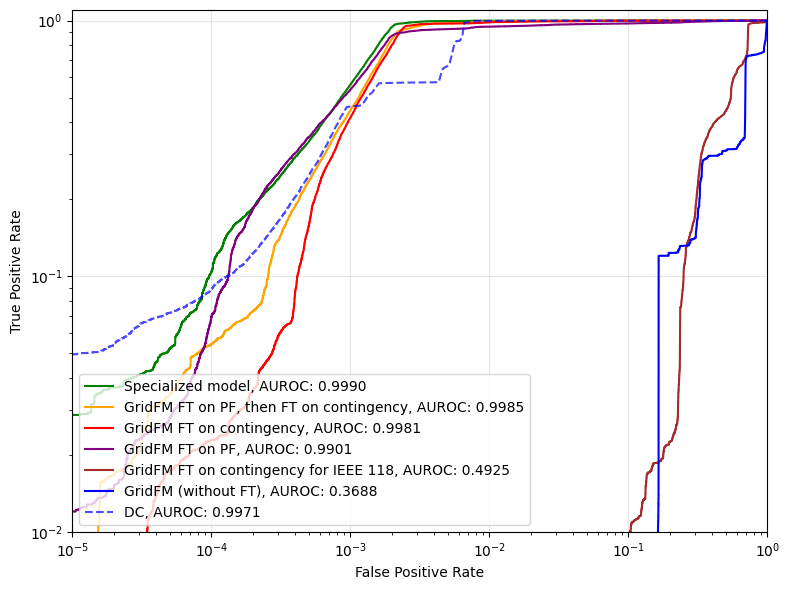

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Store results
roc_data = {}

# Compute DC ROC once (shared)
mask = removed_lines == False
y_score_dc = loadings_dc[mask]
fpr_dc, tpr_dc, thresholds_dc = roc_curve(overloadings, y_score_dc)
auc_dc = auc(fpr_dc, tpr_dc)

# Compute ROC curves and AUCs for each model prediction
for key in pf_node.keys():
    y_true = overloadings
    y_score_pred = loadings_pred[key][mask]

    fpr_pred, tpr_pred, thresholds_pred = roc_curve(y_true, y_score_pred)
    roc_data[key] = {
        "fpr_pred": fpr_pred,
        "tpr_pred": tpr_pred,
        "thresholds_pred": thresholds_pred,
        "auc_pred": auc(fpr_pred, tpr_pred)
    }

# Plotting
plt.figure(figsize=(8, 6))
target_thresholds = np.arange(0.80, 1.00, 0.02)
colors = {"contingency": "red", "no_pretraining": "green", "no_finetuning": "blue", "ft_pf_ft_contingency": "orange", "ft_pf": "purple", "ft_contingency_ieee118": "brown"}
linestyles = {"GridFM": "-", "DC": "--"}

# Plot GridFM curves and annotate thresholds
for key in pf_node.keys():
    plt.plot(roc_data[key]["fpr_pred"], roc_data[key]["tpr_pred"],
             label=f"{labels[key]}, AUROC: {roc_data[key]['auc_pred']:.4f}", linestyle=linestyles["GridFM"], color=colors[key])


# Plot shared DC curve and annotate thresholds once
plt.plot(fpr_dc, tpr_dc, label=f"DC, AUROC: {auc_dc:.4f}", linestyle=linestyles["DC"], color="blue", alpha=0.7)

# Final touches
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0.00001, 1)
plt.ylim(0.01, 1.1)
# log scale
plt.xscale("log")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Print AUCs
for key in ["contingency", "no_pretraining", "no_finetuning", "ft_pf_ft_contingency", "ft_pf", "ft_contingency_ieee118"]:
    print(f"AUROC GridFM-FT ({key}):", roc_data[key]["auc_pred"])
print(f"AUROC DC (shared):", auc_dc)

plt.savefig("comparison/loadings_fpr_tpr_all_large.pdf")


In [13]:
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import numpy as np

beta = 10


thresholds = np.linspace(0.8, 1.0,21)
best_thresholds = {}
best_scores = {}

for key in pf_node.keys() :
    best_thresh = 0.0
    best_score = 0.0

    for thresh in tqdm(thresholds, desc=f"Searching threshold for {key}"):
        y_pred = (loadings_pred[key][removed_lines == False] > thresh)
        score = fbeta_score(overloadings, y_pred, beta=beta)

        if score > best_score:
            best_score = score
            best_thresh = thresh

    best_thresholds[key] = best_thresh
    best_scores[key] = best_score
    print(f"[{key}] Best threshold: {best_thresh:.3f}, Best score: {best_score:.4f}")

# same for dc
best_thresh_dc = 0.0
best_score_dc = 0.0

for thresh in tqdm(thresholds, desc=f"Searching threshold for DC"):
    y_pred = (loadings_dc[removed_lines == False] >= thresh)
    score = fbeta_score(overloadings, y_pred, beta=beta)
    if score > best_score_dc:
        best_score_dc = score
        best_thresh_dc = thresh
print(f"[DC] Best threshold: {best_thresh_dc:.3f}, Best score: {best_score_dc:.4f}")


Searching threshold for no_pretraining: 100%|██████████| 21/21 [00:06<00:00,  3.34it/s]


[no_pretraining] Best threshold: 0.980, Best score: 0.9847


Searching threshold for ft_pf_ft_contingency: 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]


[ft_pf_ft_contingency] Best threshold: 0.890, Best score: 0.9686


Searching threshold for contingency: 100%|██████████| 21/21 [00:06<00:00,  3.34it/s]


[contingency] Best threshold: 0.980, Best score: 0.9632


Searching threshold for ft_pf: 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]


[ft_pf] Best threshold: 0.830, Best score: 0.9265


Searching threshold for ft_contingency_ieee118: 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]


[ft_contingency_ieee118] Best threshold: 0.800, Best score: 0.2556


Searching threshold for no_finetuning: 100%|██████████| 21/21 [00:06<00:00,  3.20it/s]


[no_finetuning] Best threshold: 0.850, Best score: 0.0032


Searching threshold for DC: 100%|██████████| 21/21 [00:06<00:00,  3.35it/s]

[DC] Best threshold: 0.850, Best score: 0.9770


In [14]:
from sklearn.metrics import f1_score
import numpy as np

mask = removed_lines == False
y_true = overloadings

for key in pf_node.keys():
    # Apply threshold

    y_score = loadings_pred[key][mask]
    y_pred = y_score > best_thresholds[key]

    # Confusion matrix components
    TP = np.logical_and(y_true, y_pred).sum()
    FP = np.logical_and(~y_true, y_pred).sum()
    TN = np.logical_and(~y_true, ~y_pred).sum()
    FN = np.logical_and(y_true, ~y_pred).sum()

    # Derived metrics
    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    TNR = TN / (TN + FP) if TN + FP > 0 else 0
    FNR = FN / (FN + TP) if FN + TP > 0 else 0

    print(f"\n[{labels[key]}] Threshold: {best_thresholds[key]:.3f}")
    print(f"Confusion Matrix:")
    print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
    print(f"TPR: {TPR:.3f}, FPR: {FPR:.3f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")

# same for dc
y_score = loadings_dc[mask]
y_pred = y_score >= best_thresh_dc

# Confusion matrix components
TP = np.logical_and(y_true, y_pred).sum()
FP = np.logical_and(~y_true, y_pred).sum()
TN = np.logical_and(~y_true, ~y_pred).sum()
FN = np.logical_and(y_true, ~y_pred).sum()

# Derived metrics
TPR = TP / (TP + FN) if TP + FN > 0 else 0
FPR = FP / (FP + TN) if FP + TN > 0 else 0
TNR = TN / (TN + FP) if TN + FP > 0 else 0
FNR = FN / (FN + TP) if FN + TP > 0 else 0

print(f"\n[DC] Threshold: {best_thresh_dc:.3f}")
print(f"Confusion Matrix:")
print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
print(f"TPR: {TPR:.3f}, FPR: {FPR:.3f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")



[Specialized model] Threshold: 0.980
Confusion Matrix:
TP: 16429, FP: 15065, TN: 4157839, FN: 107
TPR: 0.994, FPR: 0.004, TNR: 1.00, FNR: 0.01

[GridFM FT on PF, then FT on contingency] Threshold: 0.890
Confusion Matrix:
TP: 16333, FP: 33114, TN: 4139790, FN: 203
TPR: 0.988, FPR: 0.008, TNR: 0.99, FNR: 0.01

[GridFM FT on contingency] Threshold: 0.980
Confusion Matrix:
TP: 16079, FP: 16324, TN: 4156580, FN: 457
TPR: 0.972, FPR: 0.004, TNR: 1.00, FNR: 0.03

[GridFM FT on PF] Threshold: 0.830
Confusion Matrix:
TP: 15646, FP: 36393, TN: 4136511, FN: 890
TPR: 0.946, FPR: 0.009, TNR: 0.99, FNR: 0.05

[GridFM FT on contingency for IEEE 118] Threshold: 0.800
Confusion Matrix:
TP: 10625, FP: 2534952, TN: 1637952, FN: 5911
TPR: 0.643, FPR: 0.607, TNR: 0.39, FNR: 0.36

[GridFM (without FT)] Threshold: 0.850
Confusion Matrix:
TP: 72, FP: 618949, TN: 3553955, FN: 16464
TPR: 0.004, FPR: 0.148, TNR: 0.85, FNR: 1.00

[DC] Threshold: 0.850
Confusion Matrix:
TP: 16485, FP: 34063, TN: 4138841, FN: 51
T

# Plot pred vs true loadings

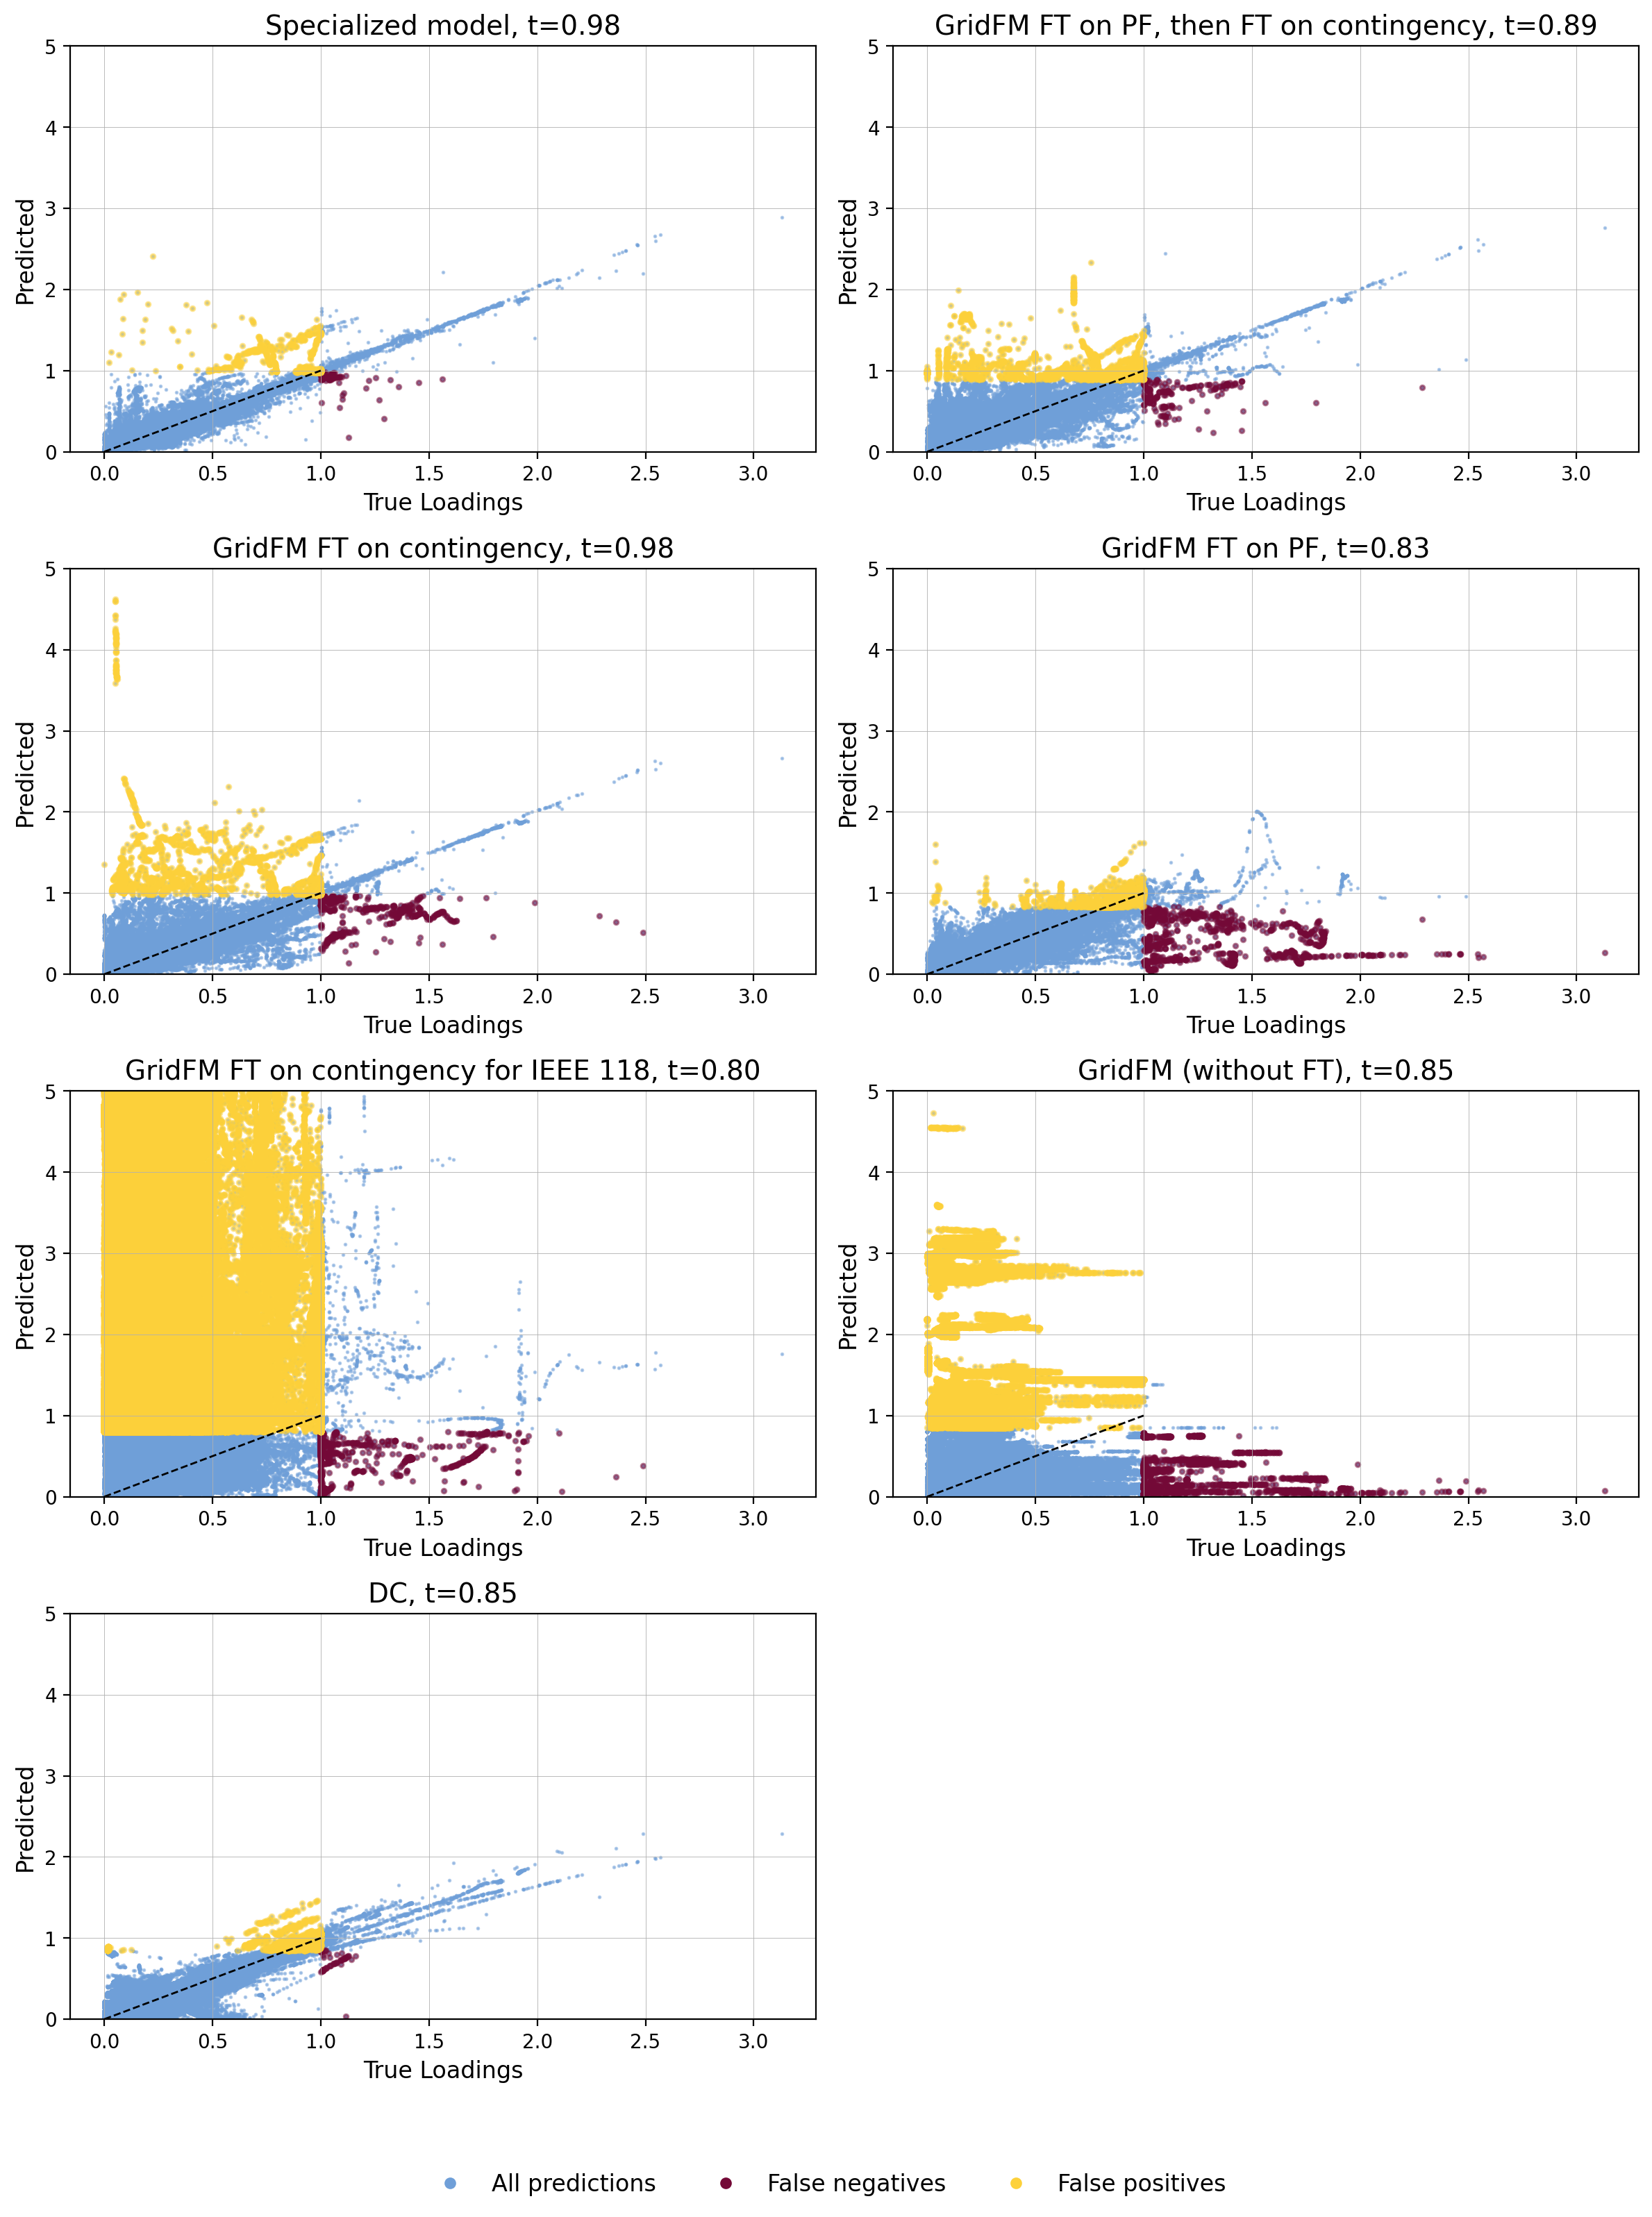

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# IBM colors
ibm_blue = "#052F5F"
ibm_prune = "#740937"
light_ibm_blue = "#6F9FD8"
ibm_yellow = "#FDD13A"


fig, axes = plt.subplots(4, 2, figsize=(12, 16), dpi=200)
axes = axes.flatten()

# Loop over models
for i, model_name in enumerate(pf_node.keys()):
    ax_model = axes[i]

    loadings_pred_model = loadings_pred[model_name]
    true_threshold = 1.00
    pred_threshold = best_thresholds[model_name]

    valid_mask = (removed_lines == False)
    fn_model_mask = (loadings > true_threshold) & (loadings_pred_model <= pred_threshold) & valid_mask
    fp_model_mask = (loadings <= true_threshold) & (loadings_pred_model > pred_threshold) & valid_mask

    ax_model.scatter(loadings[valid_mask], loadings_pred_model[valid_mask], s=1, alpha=0.5, color=light_ibm_blue)
    ax_model.scatter(loadings[fn_model_mask], loadings_pred_model[fn_model_mask], s=6, alpha=0.5, color=ibm_prune)
    ax_model.scatter(loadings[fp_model_mask], loadings_pred_model[fp_model_mask], s=6, alpha=0.5, color=ibm_yellow)
    ax_model.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax_model.set_title(f"{labels[model_name]}, t={pred_threshold:.2f}", fontsize=14)
    ax_model.set_xlabel("True Loadings", fontsize=12)
    ax_model.set_ylabel("Predicted", fontsize=12)
    ax_model.grid(True, linewidth=0.3)
    ax_model.set_ylim(0, 5)
    ax_model.tick_params(axis='both', labelsize=10)

# Add DC comparison in the 7th plot
ax_dc = axes[6]
fn_dc_mask = (loadings > true_threshold) & (loadings_dc <= pred_threshold) & valid_mask
fp_dc_mask = (loadings <= true_threshold) & (loadings_dc > pred_threshold) & valid_mask

ax_dc.scatter(loadings[valid_mask], loadings_dc[valid_mask], s=1, alpha=0.5, color=light_ibm_blue)
ax_dc.scatter(loadings[fn_dc_mask], loadings_dc[fn_dc_mask], s=6, alpha=0.5, color=ibm_prune)
ax_dc.scatter(loadings[fp_dc_mask], loadings_dc[fp_dc_mask], s=6, alpha=0.5, color=ibm_yellow)
ax_dc.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax_dc.set_title(f"DC, t={best_thresh_dc:.2f}", fontsize=14)
ax_dc.set_xlabel("True Loadings", fontsize=12)
ax_dc.set_ylabel("Predicted", fontsize=12)
ax_dc.grid(True, linewidth=0.3)
ax_dc.set_ylim(0, 5)
ax_dc.tick_params(axis='both', labelsize=10)

# Hide last (8th) subplot
axes[7].axis('off')

# Combined legend
handles = [
    plt.Line2D([], [], linestyle='none', marker='o', color=light_ibm_blue, label='All predictions', markersize=5),
    plt.Line2D([], [], linestyle='none', marker='o', color=ibm_prune, label='False negatives', markersize=5),
    plt.Line2D([], [], linestyle='none', marker='o', color=ibm_yellow, label='False positives', markersize=5)
]
fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("comparison/loadings_all_models_vs_dc.png")
plt.show()


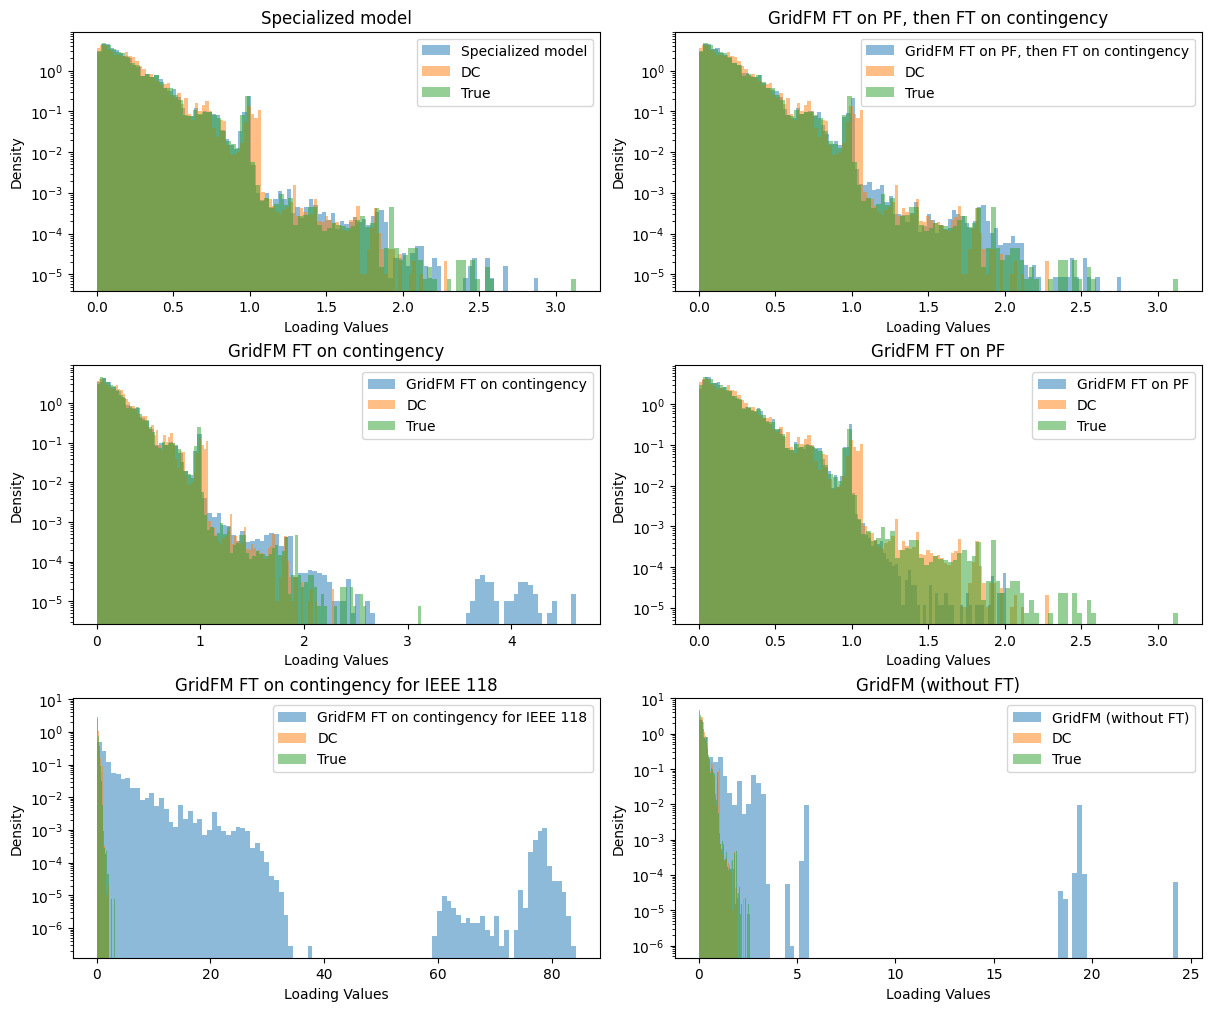

In [16]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(pf_node.keys())
n_models = len(model_names)
n_rows, n_cols = 3, 2  # 3x2 grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 10), constrained_layout=True)
axs = axs.flatten()  # Flatten to simplify indexing

for i, model_name in enumerate(model_names):
    ax = axs[i]
    ax.hist(loadings_pred[model_name][removed_lines == False], alpha=0.5, label=labels[model_name], density=True, bins=100)
    ax.hist(loadings_dc[removed_lines == False], alpha=0.5, label="DC", density=True, bins=100)
    ax.hist(loadings[removed_lines == False], alpha=0.5, label="True", density=True, bins=100)

    ax.set_xlabel("Loading Values")
    ax.set_ylabel("Density")
    ax.set_yscale("log")
    ax.set_title(labels[model_name])
    ax.legend()

# Hide any unused subplots if model_names has less than 6 entries
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.savefig("comparison/loadings_hist_all_models.pdf")
plt.show()


# Voltage violations

In [17]:
# check violations of vmax and vmin with Vm_pred_corrected and Vm
voltage_violations= abs(pf_node['contingency']["Vm"]-1) > 0.06
voltage_over_threshold = pf_node['contingency']["Vm"] > 1.06
voltage_under_threshold = pf_node['contingency']["Vm"] < 0.94





AUROC GridFM-FT (no_pretraining): 0.9594326704536541
AUROC GridFM-FT (ft_pf_ft_contingency): 0.9586091791983242
AUROC GridFM-FT (contingency): 0.9559509456489026
AUROC GridFM-FT (ft_pf): 0.9582080097898501
AUROC DC (shared): 0.9971373989293424


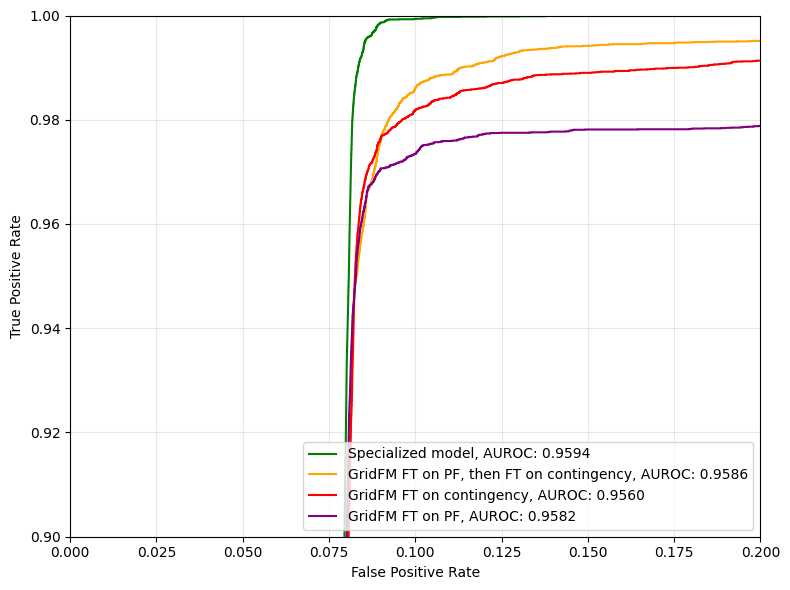

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Store results
roc_data = {}

# Compute DC ROC once (shared)

models = ["no_pretraining","ft_pf_ft_contingency","contingency", "ft_pf" ]

# Compute ROC curves and AUCs for each model prediction
for key in models:
    y_true = voltage_over_threshold
    y_score_pred = pf_node[key]["Vm_pred_corrected"]-1

    fpr_pred, tpr_pred, thresholds_pred = roc_curve(y_true, y_score_pred)
    roc_data[key] = {
        "fpr_pred": fpr_pred,
        "tpr_pred": tpr_pred,
        "thresholds_pred": thresholds_pred,
        "auc_pred": auc(fpr_pred, tpr_pred)
    }

# Plotting
plt.figure(figsize=(8, 6))
colors = {"contingency": "red", "no_pretraining": "green", "ft_pf_ft_contingency": "orange", "ft_pf": "purple"}
linestyles = {"GridFM": "-", "DC": "--"}

# Plot GridFM curves and annotate thresholds
for key in models:
    plt.plot(roc_data[key]["fpr_pred"], roc_data[key]["tpr_pred"],
             label=f"{labels[key]}, AUROC: {roc_data[key]['auc_pred']:.4f}", linestyle=linestyles["GridFM"], color=colors[key])



# Final touches
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 0.2)
plt.ylim(0.9, 1.0)
plt.grid(True, alpha=0.3)
plt.legend(loc = "lower right")
plt.tight_layout()

# Print AUCs
for key in models:
    print(f"AUROC GridFM-FT ({key}):", roc_data[key]["auc_pred"])
print(f"AUROC DC (shared):", auc_dc)

plt.savefig("comparison/voltages_over_fpr_tpr_all.pdf")


AUROC GridFM-FT (no_pretraining): 0.9975028739469017
AUROC GridFM-FT (ft_pf_ft_contingency): 0.9909641155118094
AUROC GridFM-FT (contingency): 0.9857798556324018
AUROC GridFM-FT (ft_pf): 0.9725095964157736
AUROC DC (shared): 0.9971373989293424


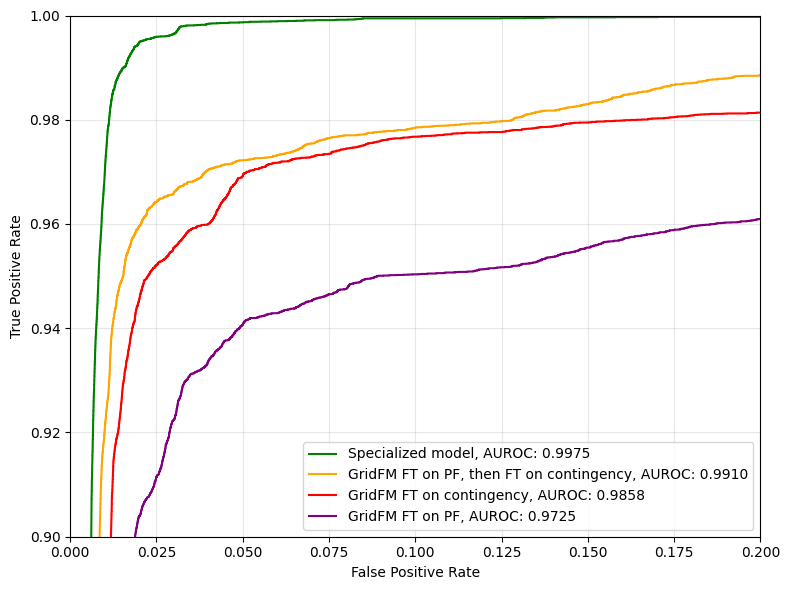

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Store results
roc_data = {}

# Compute DC ROC once (shared)

models = ["no_pretraining","ft_pf_ft_contingency","contingency", "ft_pf" ]

# Compute ROC curves and AUCs for each model prediction
for key in models:
    y_true = voltage_under_threshold
    y_score_pred = 1-pf_node[key]["Vm_pred_corrected"]

    fpr_pred, tpr_pred, thresholds_pred = roc_curve(y_true, y_score_pred)
    roc_data[key] = {
        "fpr_pred": fpr_pred,
        "tpr_pred": tpr_pred,
        "thresholds_pred": thresholds_pred,
        "auc_pred": auc(fpr_pred, tpr_pred)
    }

# Plotting
plt.figure(figsize=(8, 6))
colors = {"contingency": "red", "no_pretraining": "green", "ft_pf_ft_contingency": "orange", "ft_pf": "purple"}
linestyles = {"GridFM": "-", "DC": "--"}

# Plot GridFM curves and annotate thresholds
for key in models:
    plt.plot(roc_data[key]["fpr_pred"], roc_data[key]["tpr_pred"],
             label=f"{labels[key]}, AUROC: {roc_data[key]['auc_pred']:.4f}", linestyle=linestyles["GridFM"], color=colors[key])



# Final touches
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 0.2)
plt.ylim(0.9, 1.0)
plt.grid(True, alpha=0.3)
plt.legend(loc = "lower right")
plt.tight_layout()

# Print AUCs
for key in models:
    print(f"AUROC GridFM-FT ({key}):", roc_data[key]["auc_pred"])
print(f"AUROC DC (shared):", auc_dc)

plt.savefig("comparison/voltages_under_fpr_tpr_all.pdf")


AUROC GridFM-FT (no_pretraining): 0.9594326704536541
AUROC GridFM-FT (ft_pf_ft_contingency): 0.9586091791983242
AUROC GridFM-FT (contingency): 0.9559509456489026
AUROC GridFM-FT (ft_pf): 0.9582080097898501
AUROC GridFM-FT (ft_contingency_ieee118): 0.44825647748143854
AUROC GridFM-FT (no_finetuning): 0.6070741531427392
AUROC DC (shared): 0.9971373989293424


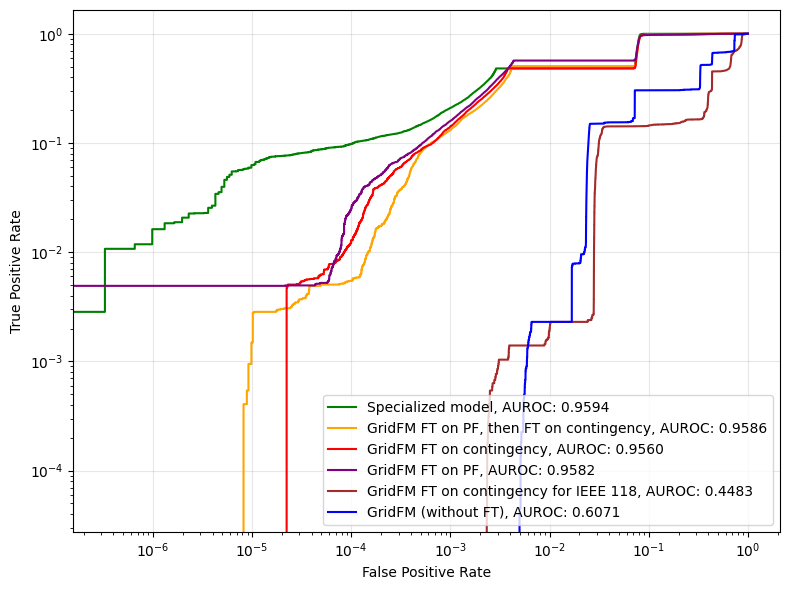

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Store results
roc_data = {}

# Compute DC ROC once (shared)


# Compute ROC curves and AUCs for each model prediction
for key in pf_node.keys():
    y_true = voltage_over_threshold
    y_score_pred = pf_node[key]["Vm_pred_corrected"]

    fpr_pred, tpr_pred, thresholds_pred = roc_curve(y_true, y_score_pred)
    roc_data[key] = {
        "fpr_pred": fpr_pred,
        "tpr_pred": tpr_pred,
        "thresholds_pred": thresholds_pred,
        "auc_pred": auc(fpr_pred, tpr_pred)
    }

# Plotting
plt.figure(figsize=(8, 6))
colors = {"contingency": "red", "no_pretraining": "green", "no_finetuning": "blue", "ft_pf_ft_contingency": "orange", "ft_pf": "purple", "ft_contingency_ieee118": "brown"}
linestyles = {"GridFM": "-", "DC": "--"}

# Plot GridFM curves and annotate thresholds
for key in pf_node.keys():
    plt.plot(roc_data[key]["fpr_pred"], roc_data[key]["tpr_pred"],
             label=f"{labels[key]}, AUROC: {roc_data[key]['auc_pred']:.4f}", linestyle=linestyles["GridFM"], color=colors[key])



# Final touches
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.xlim(0, 0.2)
# plt.ylim(0.6, 1.0)
plt.xscale("log")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend(loc = "lower right")
plt.tight_layout()

# Print AUCs
for key in pf_node.keys():
    print(f"AUROC GridFM-FT ({key}):", roc_data[key]["auc_pred"])
print(f"AUROC DC (shared):", auc_dc)

plt.savefig("comparison/voltages_over_fpr_tpr_all_large.pdf")



AUROC GridFM-FT (no_pretraining): 0.9975028739469017
AUROC GridFM-FT (ft_pf_ft_contingency): 0.9909641155118094
AUROC GridFM-FT (contingency): 0.9857798556324018
AUROC GridFM-FT (ft_pf): 0.9725095964157736
AUROC GridFM-FT (ft_contingency_ieee118): 0.5569990008127199
AUROC GridFM-FT (no_finetuning): 0.6308025572455053
AUROC DC (shared): 0.9971373989293424


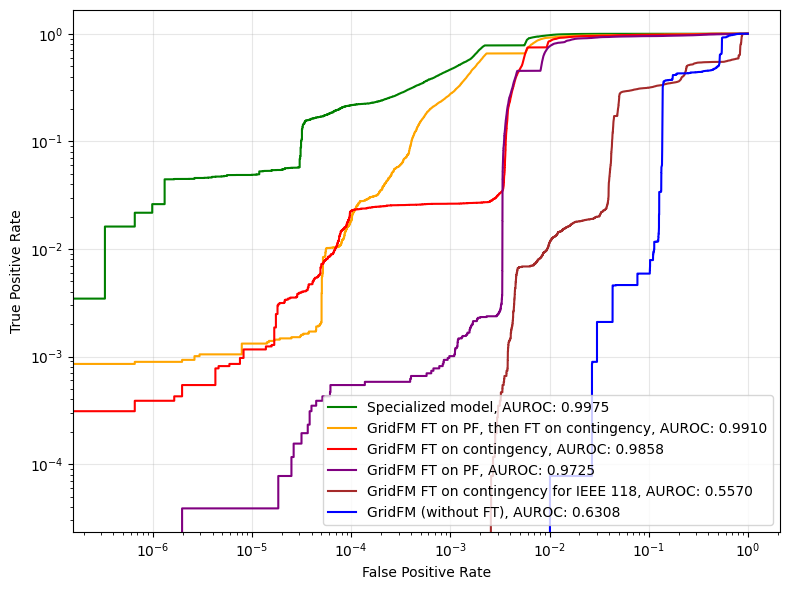

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Store results
roc_data = {}

# Compute DC ROC once (shared)


# Compute ROC curves and AUCs for each model prediction
for key in pf_node.keys():
    y_true = voltage_under_threshold
    y_score_pred = 1-pf_node[key]["Vm_pred_corrected"]

    fpr_pred, tpr_pred, thresholds_pred = roc_curve(y_true, y_score_pred)
    roc_data[key] = {
        "fpr_pred": fpr_pred,
        "tpr_pred": tpr_pred,
        "thresholds_pred": thresholds_pred,
        "auc_pred": auc(fpr_pred, tpr_pred)
    }

# Plotting
plt.figure(figsize=(8, 6))
colors = {"contingency": "red", "no_pretraining": "green", "no_finetuning": "blue", "ft_pf_ft_contingency": "orange", "ft_pf": "purple", "ft_contingency_ieee118": "brown"}
linestyles = {"GridFM": "-", "DC": "--"}

# Plot GridFM curves and annotate thresholds
for key in pf_node.keys():
    plt.plot(roc_data[key]["fpr_pred"], roc_data[key]["tpr_pred"],
             label=f"{labels[key]}, AUROC: {roc_data[key]['auc_pred']:.4f}", linestyle=linestyles["GridFM"], color=colors[key])



# Final touches
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.xlim(0, 0.2)
# plt.ylim(0.6, 1.0)
plt.xscale("log")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend(loc = "lower right")
plt.tight_layout()

# Print AUCs
for key in pf_node.keys():
    print(f"AUROC GridFM-FT ({key}):", roc_data[key]["auc_pred"])
print(f"AUROC DC (shared):", auc_dc)

plt.savefig("comparison/voltages_under_fpr_tpr_all_large.pdf")




In [20]:
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import numpy as np

beta = 10

voltage_violations= abs(pf_node['contingency']["Vm"]-1) > 0.06



thresholds = np.linspace(0.02, 0.1,17)
best_thresholds = {}
best_scores = {}

for key in pf_node.keys() :
    best_thresh = 0.0
    best_score = 0.0

    for thresh in tqdm(thresholds, desc=f"Searching threshold for {key}"):
        y_pred = abs(pf_node[key]["Vm_pred_corrected"]-1) > thresh
        score = fbeta_score(voltage_violations, y_pred, beta=beta)

        if score > best_score:
            best_score = score
            best_thresh = thresh

    best_thresholds[key] = best_thresh
    best_scores[key] = best_score
    print(f"[{key}] Best threshold: {best_thresh:.3f}, Best score: {best_score:.4f}")




Searching threshold for no_pretraining: 100%|██████████| 17/17 [00:07<00:00,  2.40it/s]


[no_pretraining] Best threshold: 0.055, Best score: 0.9187


Searching threshold for ft_pf_ft_contingency: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]


[ft_pf_ft_contingency] Best threshold: 0.055, Best score: 0.8943


Searching threshold for contingency: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]


[contingency] Best threshold: 0.055, Best score: 0.8860


Searching threshold for ft_pf: 100%|██████████| 17/17 [00:07<00:00,  2.39it/s]


[ft_pf] Best threshold: 0.055, Best score: 0.8551


Searching threshold for ft_contingency_ieee118: 100%|██████████| 17/17 [00:07<00:00,  2.29it/s]


[ft_contingency_ieee118] Best threshold: 0.020, Best score: 0.5367


Searching threshold for no_finetuning: 100%|██████████| 17/17 [00:07<00:00,  2.38it/s]

[no_finetuning] Best threshold: 0.020, Best score: 0.4613


In [21]:
from sklearn.metrics import f1_score
import numpy as np

mask = removed_lines == False
y_true = voltage_violations

for key in pf_node.keys():
    # Apply threshold

    y_pred = abs(pf_node[key]["Vm_pred_corrected"]-1) > best_thresholds[key]

    # Confusion matrix components
    TP = np.logical_and(y_true, y_pred).sum()
    FP = np.logical_and(~y_true, y_pred).sum()
    TN = np.logical_and(~y_true, ~y_pred).sum()
    FN = np.logical_and(y_true, ~y_pred).sum()

    # Derived metrics
    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    TNR = TN / (TN + FP) if TN + FP > 0 else 0
    FNR = FN / (FN + TP) if FN + TP > 0 else 0

    print(f"\n[{labels[key]}] Threshold: {best_thresholds[key]:.3f}")
    print(f"Confusion Matrix:")
    print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
    print(f"TPR: {TPR:.3f}, FPR: {FPR:.3f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")

#



[Specialized model] Threshold: 0.055
Confusion Matrix:
TP: 47609, FP: 393378, TN: 2627693, FN: 320
TPR: 0.993, FPR: 0.130, TNR: 0.87, FNR: 0.01

[GridFM FT on PF, then FT on contingency] Threshold: 0.055
Confusion Matrix:
TP: 46342, FP: 394612, TN: 2626459, FN: 1587
TPR: 0.967, FPR: 0.131, TNR: 0.87, FNR: 0.03

[GridFM FT on contingency] Threshold: 0.055
Confusion Matrix:
TP: 45999, FP: 404712, TN: 2616359, FN: 1930
TPR: 0.960, FPR: 0.134, TNR: 0.87, FNR: 0.04

[GridFM FT on PF] Threshold: 0.055
Confusion Matrix:
TP: 44375, FP: 403885, TN: 2617186, FN: 3554
TPR: 0.926, FPR: 0.134, TNR: 0.87, FNR: 0.07

[GridFM FT on contingency for IEEE 118] Threshold: 0.020
Confusion Matrix:
TP: 39368, FP: 2576092, TN: 444979, FN: 8561
TPR: 0.821, FPR: 0.853, TNR: 0.15, FNR: 0.18

[GridFM (without FT)] Threshold: 0.020
Confusion Matrix:
TP: 31385, FP: 2046902, TN: 974169, FN: 16544
TPR: 0.655, FPR: 0.678, TNR: 0.32, FNR: 0.35


no_pretraining (0.945, 1.055)
ft_pf_ft_contingency (0.945, 1.055)
contingency (0.945, 1.055)
ft_pf (0.945, 1.055)
ft_contingency_ieee118 (0.98, 1.02)
no_finetuning (0.98, 1.02)


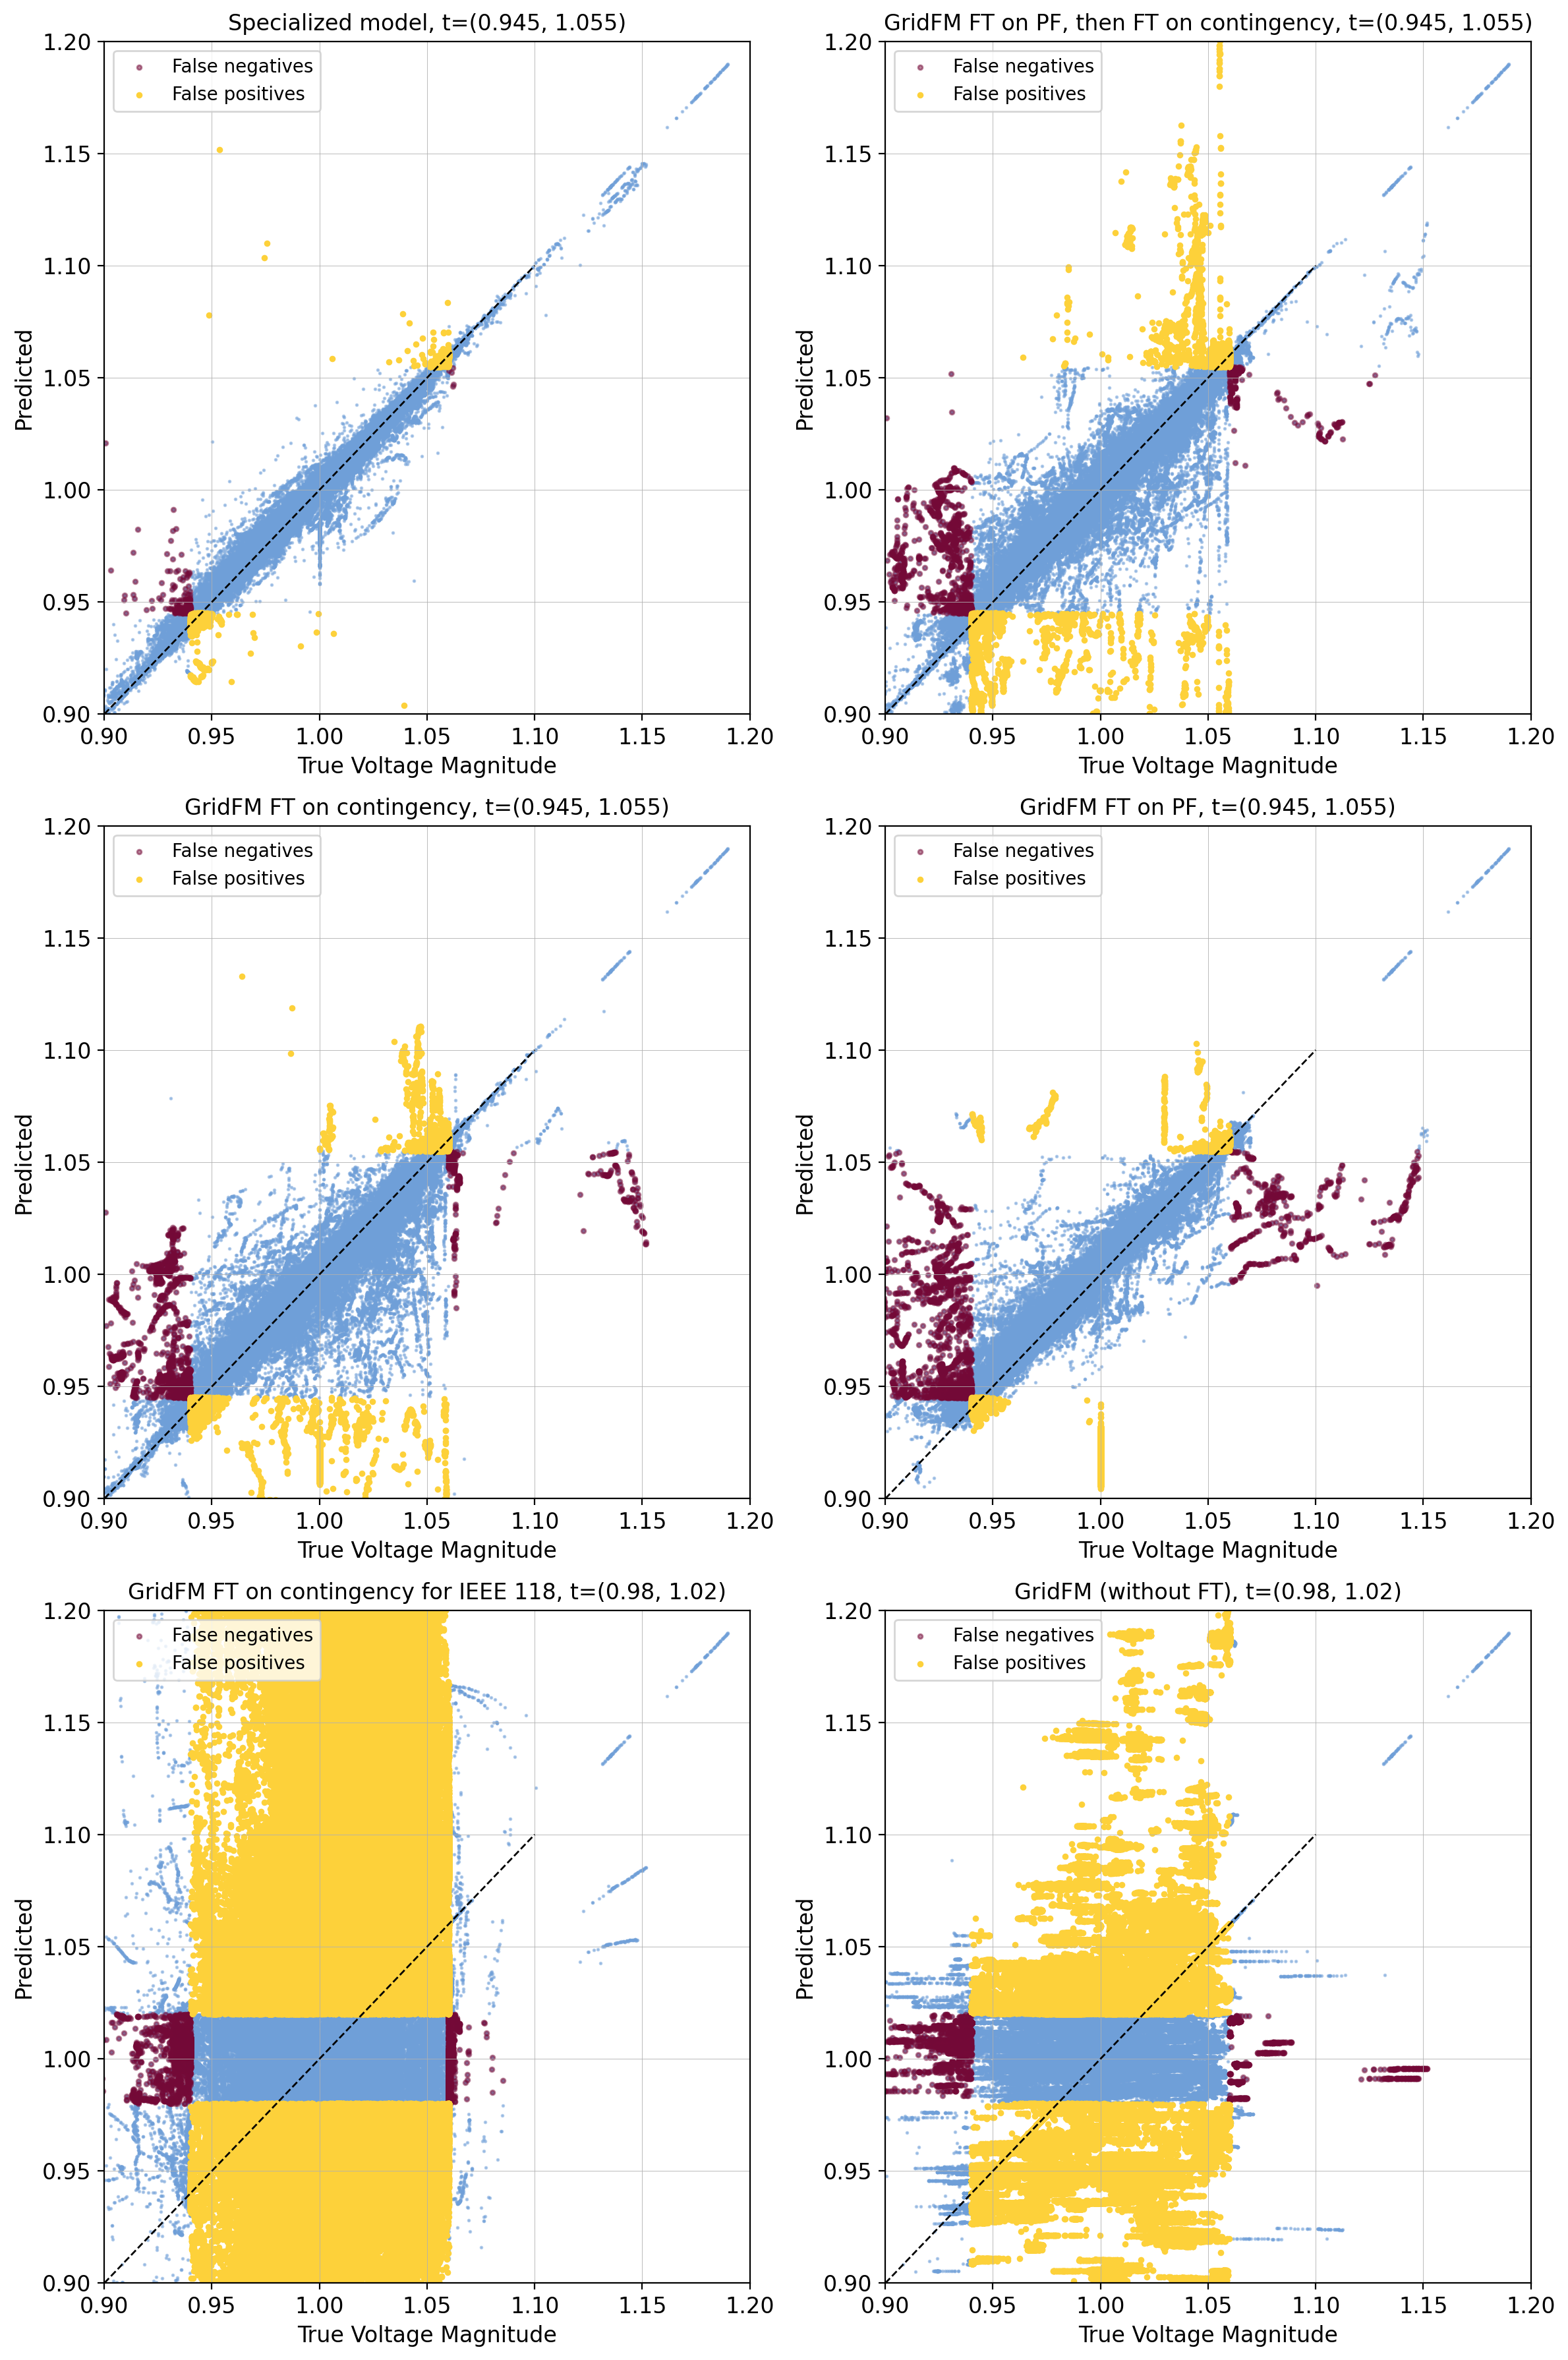

In [22]:
import matplotlib.pyplot as plt

# IBM colors
ibm_blue = "#052F5F"
ibm_prune = "#740937"
light_ibm_blue = "#6F9FD8"
ibm_yellow = "#FDD13A"

# Define voltage thresholds
vm_interval = (0.94, 1.06)

# Setup figure
fig, axs = plt.subplots(3, 2, figsize=(12, 18), dpi=200)
axs = axs.flatten()

for i, model_name in enumerate(pf_node.keys()):
    vm_pred_interval = (1-best_thresholds[model_name], 1+best_thresholds[model_name])
    print(model_name, vm_pred_interval)

    voltage_pred = pf_node[model_name]["Vm_pred_corrected"]
    voltage_true = pf_node['contingency']["Vm"]

    false_negatives = ((voltage_true < vm_interval[0]) | (voltage_true > vm_interval[1])) & \
                      ((voltage_pred >= vm_pred_interval[0]) & (voltage_pred <= vm_pred_interval[1]))

    false_positives = ((voltage_true >= vm_interval[0]) & (voltage_true <= vm_interval[1])) & \
                      ((voltage_pred < vm_pred_interval[0]) | (voltage_pred > vm_pred_interval[1]))

    ax = axs[i]
    ax.scatter(voltage_true, voltage_pred, s=1, alpha=0.5, color=light_ibm_blue)
    ax.scatter(voltage_true[false_negatives], voltage_pred[false_negatives], s=6, alpha=0.5, color=ibm_prune, label="False negatives")
    ax.scatter(voltage_true[false_positives], voltage_pred[false_positives], s=6, alpha=1, color=ibm_yellow, label="False positives")
    ax.plot([0.9, 1.1], [0.9, 1.1], 'k--', linewidth=1)

    ax.set_title(f"{labels[model_name]}, t={vm_pred_interval}", fontsize=12)
    ax.set_xlabel("True Voltage Magnitude", fontsize=12)
    ax.set_ylabel("Predicted", fontsize=12)
    ax.set_xlim(0.9, 1.2)
    ax.set_ylim(0.9, 1.2)
    ax.grid(True, linewidth=0.3)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=10, loc='upper left')

# Hide unused subplot if fewer than 6 models
for j in range(i+1, 6):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig("comparison/voltages_comparison_grid.png")
plt.show()


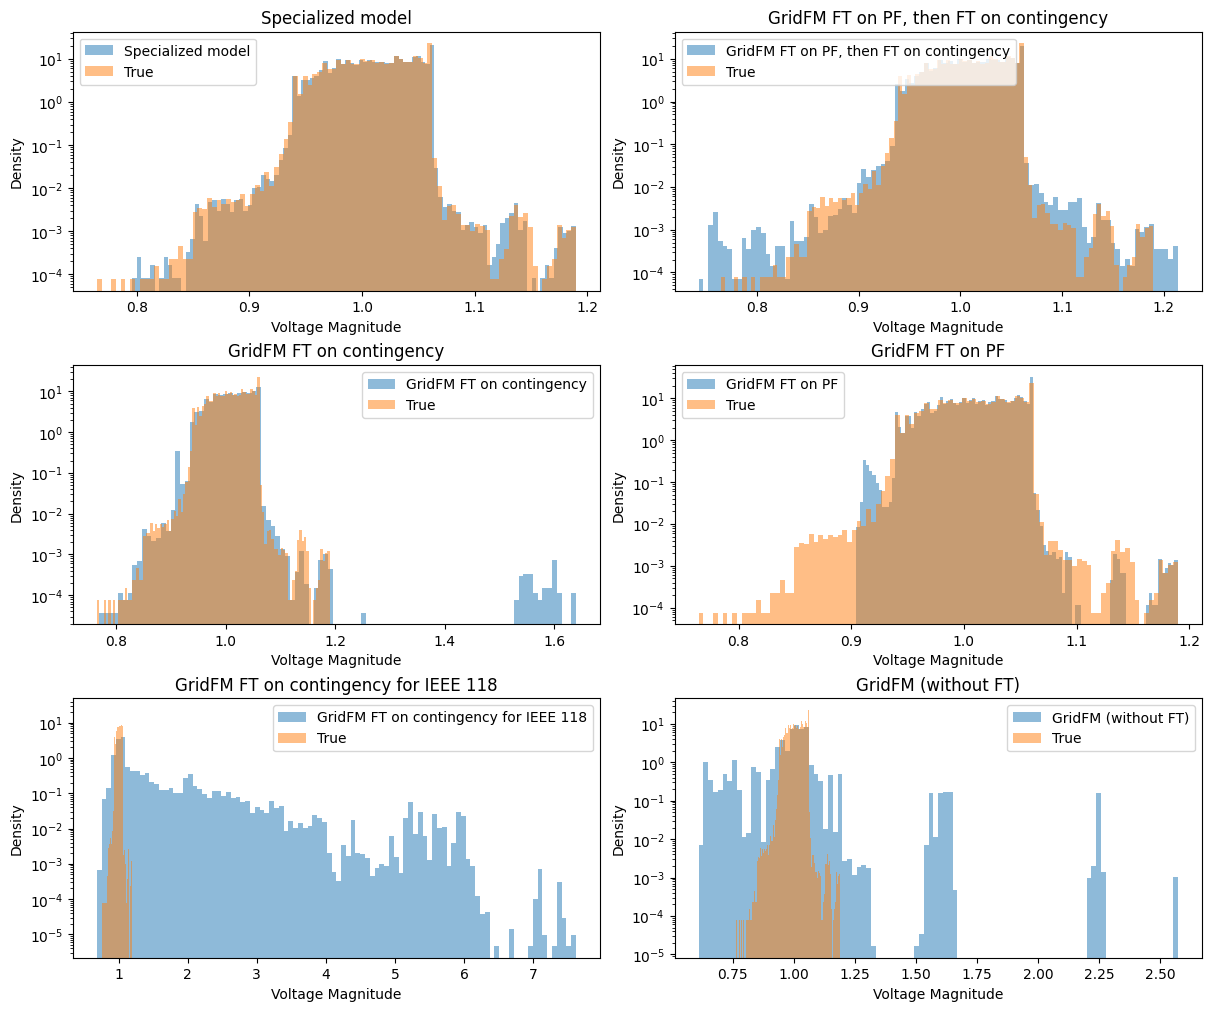

In [23]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(pf_node.keys())
n_models = len(model_names)
n_rows, n_cols = 3, 2  # 3x2 grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 10), constrained_layout=True)
axs = axs.flatten()  # Flatten to simplify indexing

for i, model_name in enumerate(model_names):
    ax = axs[i]
    ax.hist(pf_node[model_name]["Vm_pred_corrected"], alpha=0.5, label=labels[model_name], density=True, bins=100)
    ax.hist(pf_node[model_name]["Vm"], alpha=0.5, label="True", density=True, bins=100)

    ax.set_xlabel("Voltage Magnitude")
    ax.set_ylabel("Density")
    ax.set_yscale("log")
    ax.set_title(labels[model_name])
    ax.legend()

# Hide any unused subplots if model_names has less than 6 entries
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.savefig("comparison/voltages_hist_all_models.pdf")
plt.show()
